## Notebook setup

In [1]:
#import sys
#!{sys.executable} -m pip install matplotlib==3.6.3

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dynamo as dyn
import cellrank as cr
import matplotlib

from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_rows', 200)

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

cr.settings.verbosity = 1

In [6]:
dyn.get_all_dependencies_version()

package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,scikit-learn,pynndescent,pre-commit,pandas,openpyxl,numpy,numdifftools,numba,networkx,matplotlib,loompy,igraph,get-version,dynamo-release,colorcet,anndata
version,0.5.5,4.10.0,4.66.2,0.14.1,68.2.2,1.0.0,0.13.2,1.11.4,1.1.3,0.5.11,3.6.2,2.2.1,3.1.2,1.26.4,0.9.41,0.59.0,3.2.1,3.6.3,3.0.7,0.10.8,3.5.5,1.4.0,3.1.0,0.10.5.post1


In [7]:
dyn.configuration.set_figure_params('dynamo', background='white', vector_friendly=True, transparent=True)

In [8]:
user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])
user_defined_palette_incmap = LinearSegmentedColormap.from_list('mycmap', [ '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#AA0DFE','#FEAF16', '#325A9B', '#C075A6'])


user_defined_palette =  [ '#F6222E', '#FEAF16','#3283FE','#BDCDFF', '#3B00FB', '#F8A19F', '#1CFFCE',  '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F','#B5EFB5', '#0e452b', '#AA0DFE']


In [9]:
%matplotlib inline 

# Conventional scRNA-seq

### Load data

In [10]:
path_to_h5ad = '../output/anndata_io/18mo_TEC+loom.h5ad'

In [11]:
adata = dyn.read_h5ad(path_to_h5ad)

In [12]:
preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
preprocessor.preprocess_adata(adata, recipe='monocle')

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 4 outlier cells
|-----------> filtered out 20229 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [185.6715s]
|-----> [Cell Cycle Scores Estimation] completed [0.1931s]
|-----> [Preprocessor-monocle] completed [39.0332s]


In [13]:
preprocessor.filter_cells_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_expr_genes_s": 300,
    "min_expr_genes_u": 100,
    "min_expr_genes_p": 50,
    "max_expr_genes_s": np.inf,
    "max_expr_genes_u": np.inf,
    "max_expr_genes_p": np.inf,
    "shared_count": None,
}

In [14]:
preprocessor.filter_genes_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_cell_s": 3,
    "min_cell_u": 2,
    "min_cell_p": 1,
    "min_avg_exp_s": 0,
    "min_avg_exp_u": 0,
    "min_avg_exp_p": 0,
    "max_avg_exp": np.inf,
    "min_count_s": 5,
    "min_count_u": 0,
    "min_count_p": 0,
    "shared_count": 40,
}

In [15]:
preprocessor.select_genes_kwargs = {
    "n_top_genes": 5000,
    "sort_by": "cv_dispersion",
    "keep_filtered": True,
    "SVRs_kwargs": {
        "relative_expr": True,
        "total_szfactor": "total_Size_Factor",
        "min_expr_cells": 0,
        "min_expr_avg": 0,
        "max_expr_avg": np.inf,
        "winsorize": False,
        "winsor_perc": (1, 99.5),
        "sort_inverse": False,
        "svr_gamma": None,
    },
}

In [16]:
preprocessor.preprocess_adata_monocle(adata )

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 19 outlier cells
|-----------> filtered out 20581 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [34.4081s]
|-----> [Cell Cycle Scores Estimation] completed [0.2122s]
|-----> [Preprocessor-monocle] completed [34.3984s]


In [17]:
dyn.tl.dynamics(adata, model='stochastic', cores=7)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----? layer X_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_variance_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Ms is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, ski

AnnData object with n_obs × n_vars = 3768 × 25526
    obs: 'sample', 'stage', 'day', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'mito_frac', 'ribo_frac', 'hb_frac', 'doublet_score', 'predicted_doublet', 'n_counts', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.2', 'leiden_1.4', 'leiden_1.6', 'leiden_1.8', 'leiden_2.0', 'leiden_0.1', 'leiden_0.3', 'leiden_0.5', 'leiden_0.7', 'leiden_0.9', 'cell_type', 'cTEC', 'mTEC1', 'mTEC2', 'mTEC3(a)', 'mTEC3(b)', 'mTEC3(c)', 'mTEC4', 'pre-Aire mTEC1', 'pre-Aire mTEC2', 'prol mTEC', 'mat mTEC1', 'mat mTEC2', 'mat mTEC3', 'post-Aire mTEC1', 'post-Aire mTEC2', 'post-Aire mTEC3', 'GP2-pref mTEC', 'tuft-like mTEC', 'unknown TEC', 'fibroblast-like1', 'fibroblast-like2', 'ciliated TEC', 'per_cTEC', 'mat_c

In [18]:
dyn.tl.cell_velocities(adata, method='pearson', use_neg_vals=False, other_kernels_dict={'transform': 'sqrt'})

|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [4.1315s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2871s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 3768 × 25526
    obs: 'sample', 'stage', 'day', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'mito_frac', 'ribo_frac', 'hb_frac', 'doublet_score', 'predicted_doublet', 'n_counts', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.2', 'leiden_1.4', 'leiden_1.6', 'leiden_1.8', 'leiden_2.0', 'leiden_0.1', 'leiden_0.3', 'leiden_0.5', 'leiden_0.7', 'leiden_0.9', 'cell_type', 'cTEC', 'mTEC1', 'mTEC2', 'mTEC3(a)', 'mTEC3(b)', 'mTEC3(c)', 'mTEC4', 'pre-Aire mTEC1', 'pre-Aire mTEC2', 'prol mTEC', 'mat mTEC1', 'mat mTEC2', 'mat mTEC3', 'post-Aire mTEC1', 'post-Aire mTEC2', 'post-Aire mTEC3', 'GP2-pref mTEC', 'tuft-like mTEC', 'unknown TEC', 'fibroblast-like1', 'fibroblast-like2', 'ciliated TEC', 'per_cTEC', 'mat_c

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type


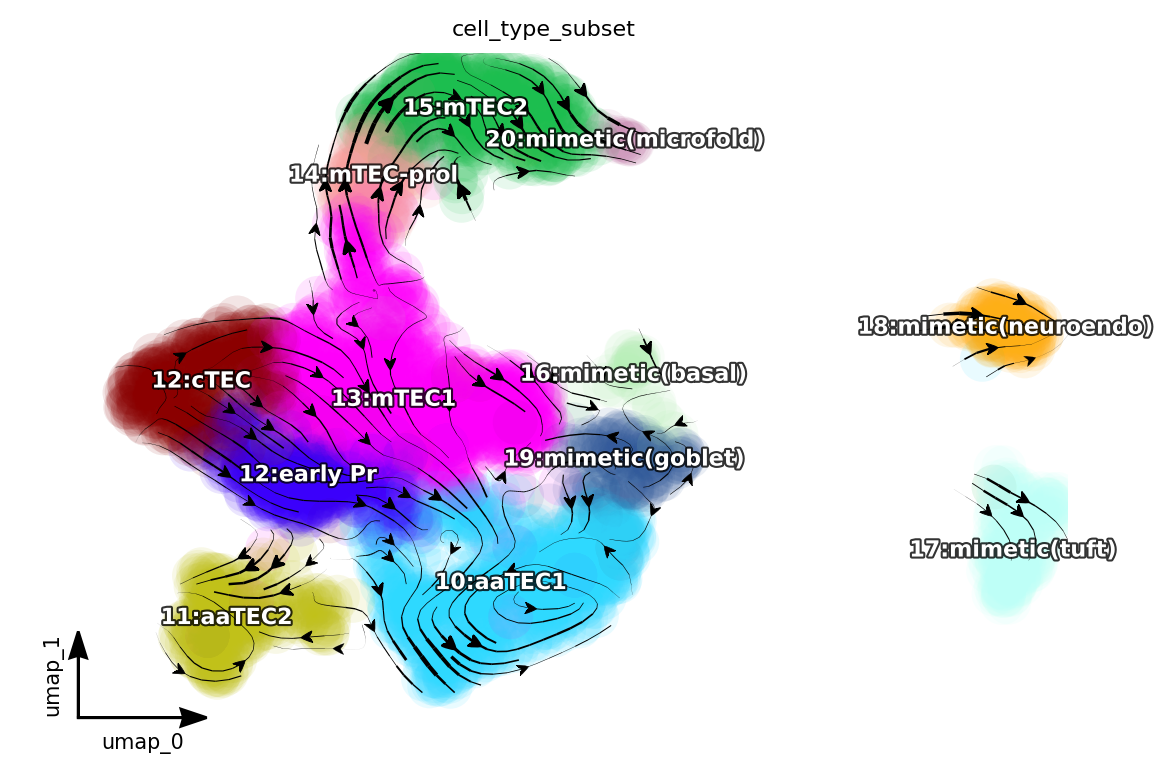

In [22]:
dyn.pl.streamline_plot(adata, color=['cell_type_subset'], basis='umap',  color_key=['#2ED9FF', '#c1c119',  '#8b0000','#3b00fb', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5', '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6'], show_legend='on data', cmap='Spectral_r', show_arrowed_spines=True)

## Reconstruct vector field

In [23]:
dyn.vf.VectorField(adata, basis='umap', M=1000, MaxIter=170, pot_curl_div=True)
#dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)
#dyn.vf.VectorField(adata, basis="pca", pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [107.5606s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [107.3981s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 2-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----

Calculating 2-D curl: 100%|██████████████| 3768/3768 [00:00<00:00, 16313.66it/s]

|-----> Computing divergence...



Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00, 42.43it/s]

|-----> [VectorField] completed [565.0866s]


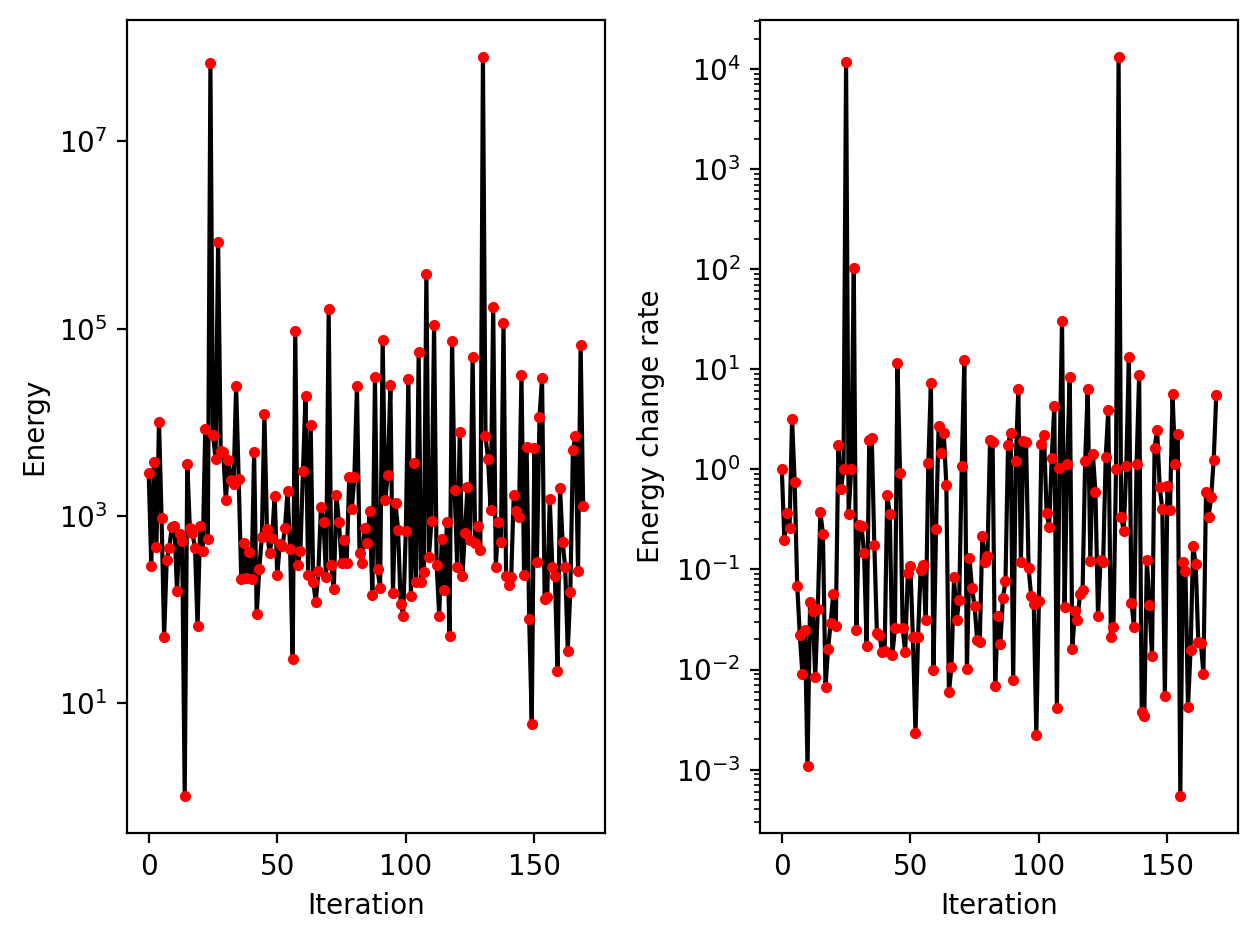

In [24]:
dyn.pl.plot_energy(adata, basis='umap')

## Characterize vector field topology

In [25]:
dyn.configuration.set_figure_params('dynamo', figsize=(6, 4), dpi=80, dpi_save=300, background='white', vector_friendly=True, transparent=True)

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type


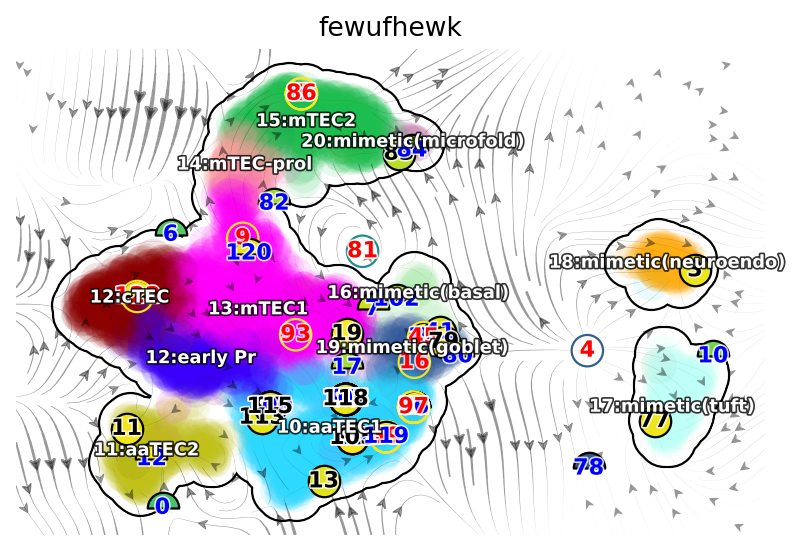

In [26]:
ax = dyn.pl.topography(adata, basis='umap', background='white', color=['cell_type_subset'], cmap='Spectral_r', color_key=['#2ED9FF', '#c1c119',  '#8b0000','#3b00fb', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5', '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6'], streamline_color='black', save_show_or_return='return', show_legend='on data', frontier=True)
ax.set_title('fewufhewk')

plt.show()

## Beyond RNA velocity

In [27]:
dyn.tl.cell_velocities(adata, basis='pca')
dyn.vf.VectorField(adata, basis='pca')
dyn.vf.speed(adata, basis='pca')
dyn.vf.curl(adata, basis='umap')
dyn.vf.divergence(adata, basis='pca')
dyn.vf.acceleration(adata, basis='pca')
dyn.vf.curvature(adata, basis='pca')

Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2768s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [3.2562s]
|-----> [VectorField] completed [3.3297s]


Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00, 23.40it/s]


|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.1082s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0938s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.0703s]


|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type


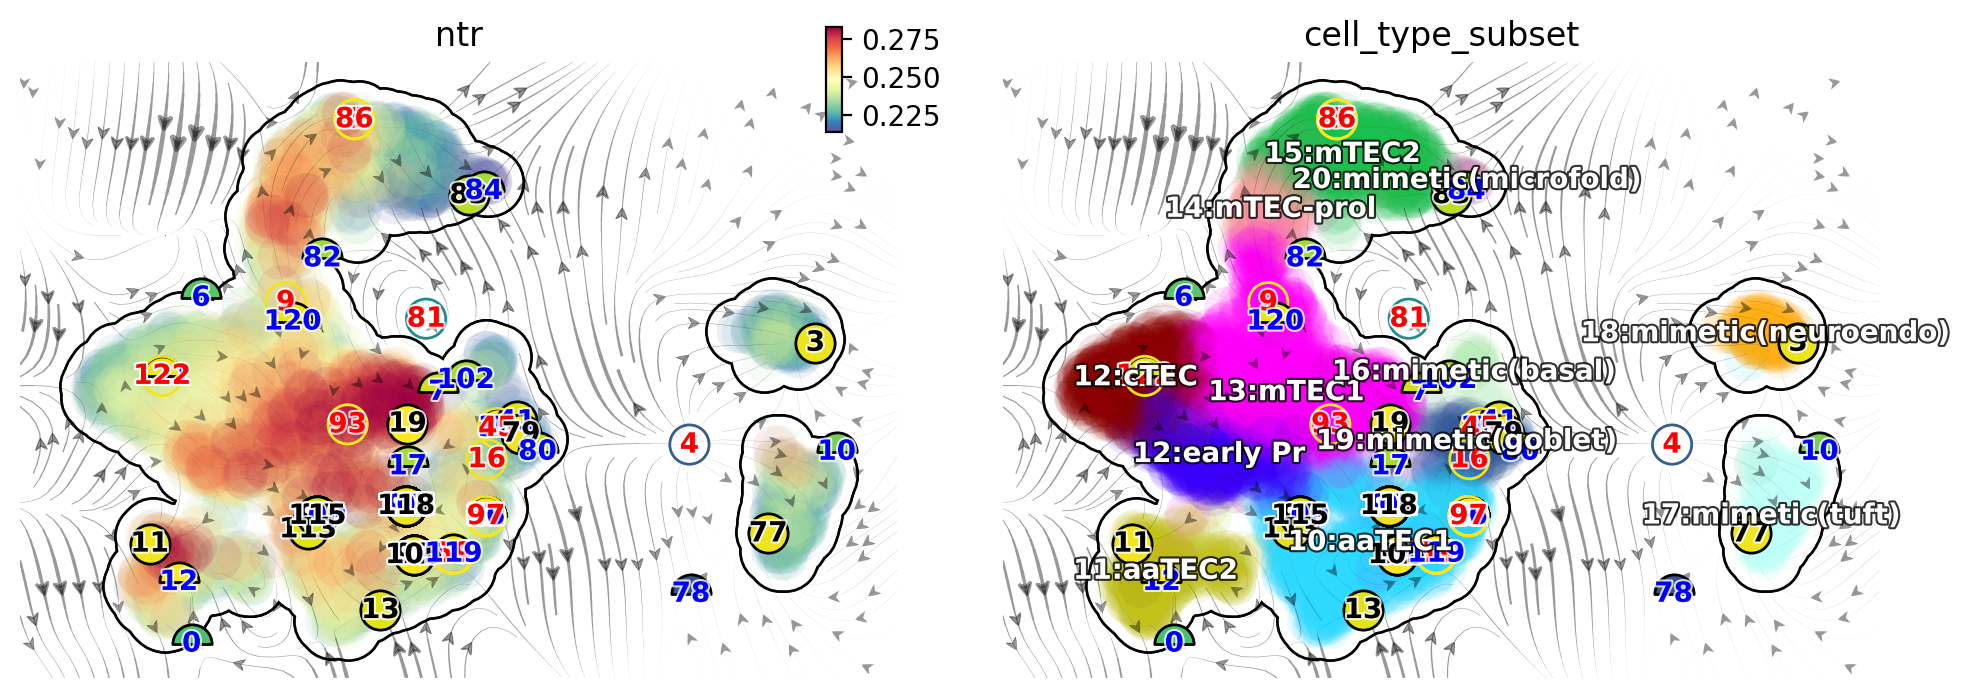

In [28]:
dyn.pl.topography(adata, basis='umap', background='white', color=['ntr', 'cell_type_subset'], cmap='Spectral_r', color_key=['#2ED9FF', '#c1c119',  '#8b0000','#3b00fb', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5', '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6'],  streamline_color='black', show_legend='on data', frontier=True)

## Animate fate transition

In [31]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128 # Ensure all frames will be embedded.

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [34]:
%%capture
panel_titles = ["aaTEC1 (18mo)", "aaTEC2 (18mo)", "cTEC (18mo)", "$\mathregular{Early^{prog}}$ (18mo)", "mTEC1 (18mo)", "$\mathregular{mTEC^{prol}}$ (18mo)", "mTEC2 (18mo)",
                     "$\mathregular{mimetic^{(basal)}}$ (18mo)", "$\mathregular{mimetic^{(tuft)}}$ (18mo)", "$\mathregular{mimetic^{(neuro)}}$ (18mo)", "$\mathregular{mimetic^{(goblet)}}$ (18mo)",
                     "$\mathregular{mimetic^{(M-cell)}}$ (18mo)"]

index=0

for subset in ["10:aaTEC1", "11:aaTEC2", "12:cTEC", "12:early Pr", "13:mTEC1", "14:mTEC-prol", "15:mTEC2",
                     "16:mimetic(basal)", "17:mimetic(tuft)", "18:mimetic(neuroendo)", "19:mimetic(goblet)",
                     "20:mimetic(microfold)"]:
    dyn.pd.fate(adata, basis='umap', init_cells=adata.obs_names[adata.obs.cell_type_subset.isin([subset])], interpolation_num=100,  direction='forward',
                inverse_transform=False, average=False, cores=7)
    fig, ax = plt.subplots()
    ax = dyn.pl.topography(adata, color='cell_type_subset', color_key=['#2ED9FF', '#c1c119',  '#8b0000','#3b00fb', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5', '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6'], ax=ax, save_show_or_return='return')
    ax.set_title(panel_titles[index])
    dyn.mv.animate_fates(adata, color='cell_type_subset', basis='umap', n_steps=100, fig=fig, ax=ax,
                     save_show_or_return='save', logspace=True,  max_time=None, save_kwargs = {"dpi": 300,  "filename": 'fateani - '+str(panel_titles[index])+'.gif'})
    
    index=index+1

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type
|-----? the number of cell states with fate prediction is more than 50. You may want to lower the max number of cell states to draw via cell_states argument.
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type
|-----? the number of cell states with fate prediction is more than 50. You may want to lower the max number of cell states to draw via cell_states argument.
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type_subset by stack threshold when stacking color because it is not a numeric type
|-----? the number of cell states with fate prediction is more than 50. You may want to lower the max number of cell states to draw via cell_states argument.
|-----------> plotting with basis key

In [27]:
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2


In [29]:
from cellrank.kernels import PseudotimeKernel

dd = PseudotimeKernel(adata, time_key="umap_ddhodge_potential")

In [30]:
dd.transition_matrix = adata.obsp['pearson_transition_matrix']

In [32]:
adata.obs["umap_ddhodge_potential"].max()

4.409487731794678

In [36]:
adata.uns["cell_type_subset_colors"] = ['#2ED9FF', '#c1c119',  '#8b0000','#3b00fb', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5', '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6']

In [37]:
bins = [0,1,2,3,4,5]
adata.obs["umap_ddhodge_potential_binned"] = np.searchsorted(bins, adata.obs["umap_ddhodge_potential"].tolist())

In [49]:
dyn.configuration.set_figure_params('dynamo', figsize=(6, 4), dpi=80, dpi_save=300, background='white', vector_friendly=True, transparent=True)

In [40]:
ax = dd.plot_single_flow(
    cluster_key="cell_type_subset",
    time_key="umap_ddhodge_potential_binned",
    cluster="13:mTEC1",
    xticks_step_size=1,
    show=False,
        
    clusters=[ "10:aaTEC1", "11:aaTEC2", "12:cTEC",  "13:mTEC1", "12:early Pr", "14:mTEC-prol", "15:mTEC2", "16:mimetic(basal)"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Computing flow from `13:mTEC1` into `7` cluster(s) in `5` time points
Plotting flow from `13:mTEC1` into `7` cluster(s) in `5` time points


In [41]:
plt.savefig('figures/single_flow_mTEC1.pdf')

In [42]:
ax = dd.plot_single_flow(
    cluster_key="cell_type_subset",
    time_key="umap_ddhodge_potential_binned",
    cluster= "12:early Pr",
    xticks_step_size=1,
    show=False,
        
    clusters=[ "10:aaTEC1", "11:aaTEC2", "12:cTEC",  "13:mTEC1", "12:early Pr", "14:mTEC-prol", "15:mTEC2", "16:mimetic(basal)"],
    )

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Computing flow from `12:early Pr` into `7` cluster(s) in `5` time points
Plotting flow from `12:early Pr` into `4` cluster(s) in `5` time points


In [43]:
plt.savefig('figures/single_flow_earlyPr.pdf')

In [44]:
ax = dd.plot_single_flow(
    cluster_key="cell_type_subset",
    time_key="umap_ddhodge_potential_binned",
    cluster= "12:cTEC",
    xticks_step_size=1,
    show=False,
        
    clusters=[ "10:aaTEC1", "11:aaTEC2", "12:cTEC",  "13:mTEC1", "12:early Pr", "14:mTEC-prol", "15:mTEC2", "16:mimetic(basal)"],
    )

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Computing flow from `12:cTEC` into `7` cluster(s) in `5` time points
Plotting flow from `12:cTEC` into `6` cluster(s) in `5` time points


In [45]:
plt.savefig('figures/single_flow_cTEC.pdf')

In [46]:
ax = dd.plot_single_flow(
    cluster_key="cell_type_subset",
    time_key="umap_ddhodge_potential_binned",
    cluster= "14:mTEC-prol",
    xticks_step_size=1,
    show=False,
        
    clusters=[ "10:aaTEC1", "11:aaTEC2", "12:cTEC",  "13:mTEC1", "12:early Pr", "14:mTEC-prol", "15:mTEC2", "16:mimetic(basal)"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Computing flow from `14:mTEC-prol` into `7` cluster(s) in `5` time points
Plotting flow from `14:mTEC-prol` into `2` cluster(s) in `5` time points


In [47]:
plt.savefig('figures/single_flow_mTEC-prol.pdf')

In [48]:
ax = dd.plot_single_flow(
    cluster_key="cell_type_subset",
    time_key="umap_ddhodge_potential_binned",
    cluster= "11:aaTEC2",
    xticks_step_size=1,
    show=False,
        
    clusters=[ "10:aaTEC1", "11:aaTEC2", "12:cTEC",  "13:mTEC1", "12:early Pr", "14:mTEC-prol", "15:mTEC2", "16:mimetic(basal)"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Computing flow from `11:aaTEC2` into `7` cluster(s) in `5` time points
Plotting flow from `11:aaTEC2` into `3` cluster(s) in `5` time points


In [49]:
plt.savefig('figures/single_flow_aaTEC2.pdf')